# Quantum Auto-Regressive Model Training
**Objective:** Train a Hybrid Quantum-Classical Neural Network to predict the next token in a molecular sequence, conditioned on global molecular properties (logP, QED, MW).

**Architecture:**
* **Input:** 5-bit token encodings + 3 continuous property values.
* **Ansatz:** A variational quantum circuit using Strongly Entangling Layers and Diagonal Phase rotations ($e^{-i \phi Z \otimes Z}$).
* **Training:** JAX-based optimization using the Adam optimizer.

In [1]:
from typing import Tuple, List, Dict, Any

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import QED
from rdkit.Chem import Draw
from IPython.display import display
import selfies as sf

import numpy as np
import math
from math import ceil, log2, comb
import re
import pandas as pd
import optax
import csv
import json
import itertools
from functools import partial
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

import pennylane as qml
from pennylane.templates import StronglyEntanglingLayers

import jax
import jax.random as random
from jax import random
import jax.numpy as jnp
import jax.nn as jnn
from jax.nn.initializers import normal


# Data Preparation

In [2]:
# Load metadata from JSON
N_MOLECS = 1000
META_DATA_PATH = f"../data/metadata_selfies_{N_MOLECS}.json"
TIMESTAMP = time.strftime("%d%m%Y_%H")

with open(META_DATA_PATH, "r") as f:
    metadata = json.load(f)

VOCABULARY_SIZE = metadata['vocabulary_size']
BITS_PER_TOKEN = metadata['bits_per_token']
MAX_LEN = metadata['max_sequence_length']
ALPHABET = metadata['alphabet']
min_logp = metadata['min_logP']
max_logp = metadata['max_logP']
min_qed = metadata['min_qed']
max_qed = metadata['max_qed']
min_mw = metadata['min_mw']
max_mw = metadata['max_mw']

print("Vocabulary Size:", VOCABULARY_SIZE)
print("Bits per Token:", BITS_PER_TOKEN)
print("Max Sequence Length:", MAX_LEN)
print("Alphabet:", ALPHABET)


Vocabulary Size: 30
Bits per Token: 5
Max Sequence Length: 31
Alphabet: ['<SOS>', '[#Branch1]', '[#Branch2]', '[#C]', '[#N]', '[=Branch1]', '[=Branch2]', '[=C]', '[=N]', '[=O]', '[=P]', '[=Ring1]', '[=S]', '[Br]', '[Branch1]', '[Branch2]', '[C]', '[Cl]', '[F]', '[I]', '[NH1]', '[N]', '[O]', '[PH1]', '[P]', '[Ring1]', '[Ring2]', '[S]', '<EOS>', '<PAD>']


In [3]:
# --- Auxiliary functions ---

def normalize(value, min_val, max_val, target_max=np.pi):
    ''' Normalize a value to a range [0, [0, pi] to later encode them as rotation angles'''
    norm = (value - min_val) / (max_val - min_val) * target_max
    return float(f"{norm:.3f}")

def denormalize(norm_value, min_val, max_val, target_max=np.pi):
    ''' Denormalize a value from [0, pi] back to its original range'''
    return (norm_value * (max_val - min_val) / target_max) + min_val

def token_to_index(token):
    ''' Map a SELFIES token to its corresponding index in the ALPHABET'''
    if token in ALPHABET:
        return ALPHABET.index(token)
    else:
        return None

def bits_to_index(bits):
    powers = 2 ** jnp.arange(len(bits) - 1, -1, -1)
    return jnp.dot(bits, powers).astype(jnp.int32)

In [4]:
PAD_index = token_to_index("<PAD>")
SOS_index = token_to_index("<SOS>")
EOS_index = token_to_index("<EOS>")

In [5]:
def load_dataset_bits_batch(csv_path, n_bits=BITS_PER_TOKEN):
    """
    Read the dataset from a CSV file and convert it into bit representations for quantum processing.
    Args:
        csv_path (str): Path to the CSV file containing the dataset.
        n_bits (int): Number of bits used to represent each token.
    Returns:
        Tuple containing:
            - X_bits (jnp.ndarray): Input bit representations of shape (N_Molecules, MAX_LEN-1, n_bits).
            - Props (jnp.ndarray): Molecular properties of shape (N_Molecules, 3).
            - Y_indices (jnp.ndarray): Target token indices of shape (N_Molecules, MAX_LEN-1).
    """
    
    df = pd.read_csv(csv_path, dtype=str)
    print("Dataset loaded with shape:", df.shape)
    
    # Properties: logP, qed, mw
    # Shape: (N_Moleculas, 3)
    # Types: float
    props = df.iloc[:, :3].astype(float).values
    
    # Tokens
    # Shape: (N_Moleculas, MAX_LEN)
    # Types: string (e.g., "00101")
    token_cols = df.iloc[:, 3:].values
    
    # Auxiliary function to convert a string of '0's and '1's to a list
    def str_to_bit_list(s):
        return [int(c) for c in s]

    # 3D array to hold all bits
    all_bits = np.array([
        [str_to_bit_list(token) for token in row] 
        for row in token_cols
    ])
    
    # X_bits: Input for the model.
    # Take all tokens except the last one.
    X_bits = all_bits[:, :-1, :] 
    
    # Y_ind: Target indices for the model.
    # Take all tokens except the first one.
    # Convert from bit strings to integer indices (for loss calculation).
    Y_indices = np.array([[int(t, 2) for t in row[1:]] for row in token_cols])

    return jnp.array(X_bits), jnp.array(props), jnp.array(Y_indices)


In [6]:
data_path_train = f"../data/structured_data_selfies_{N_MOLECS}_train.csv"
print("Loaded training data:")
X_bits, Props, Y_ind = load_dataset_bits_batch(data_path_train)

print("X_bits shape:", X_bits.shape) # (N, L, 5)
print("Props shape:", Props.shape)   # (N, 3)
print("Y_ind shape:", Y_ind.shape)   # (N, L)
print("------------------------------")


data_path_val = f"../data/structured_data_selfies_{N_MOLECS}_val.csv"
print("Loaded validation data:")
X_bits_val, Props_val, Y_ind_val = load_dataset_bits_batch(data_path_val)

print("X_bits shape:", X_bits_val.shape) # (N, L, 5)
print("Props shape:", Props_val.shape)   # (N, 3)
print("Y_ind shape:", Y_ind_val.shape)   # (N, L)
print("------------------------------")


data_path_test = f"../data/structured_data_selfies_{N_MOLECS}_test.csv"
print("Loaded validation data:")
X_bits_test, Props_test, Y_ind_test = load_dataset_bits_batch(data_path_test)

print("X_bits shape:", X_bits_test.shape) # (N, L, 5)
print("Props shape:", Props_test.shape)   # (N, 3)
print("Y_ind shape:", Y_ind_test.shape)   # (N, L)

Loaded training data:
Dataset loaded with shape: (667, 34)
X_bits shape: (667, 30, 5)
Props shape: (667, 3)
Y_ind shape: (667, 30)
------------------------------
Loaded validation data:
Dataset loaded with shape: (143, 34)
X_bits shape: (143, 30, 5)
Props shape: (143, 3)
Y_ind shape: (143, 30)
------------------------------
Loaded validation data:
Dataset loaded with shape: (143, 34)
X_bits shape: (143, 30, 5)
Props shape: (143, 3)
Y_ind shape: (143, 30)


## Quantum Circuit

### Attention Computation

The model utilizes a classical attention mechanism to maintain context over the sequence generation.

In [7]:
def batched_causal_attention(Q, K, V, mask_value=-1e9):
    """
    Computes attention for the whole batch (B, L, E) at once.
    Args:
        Q: Query matrix, shape (B, L, E)
        K: Key matrix, shape (B, L, E)
        V: Value matrix, shape (B, L, E)
        mask_value: Value to use for masked positions (default: -1e9)
    Returns:
        Output matrix after attention, shape (B, L, E)
    """
    d_k = Q.shape[-1] 
    
    # Transpose last two dimensions of K for matrix multiplication
    K_swap = K.swapaxes(-1, -2)  # (B, E, L)

    # Calculate scores: (B, L, E) @ (B, E, L) -> (B, L, L)
    scores = jnp.matmul(Q, K_swap) / jnp.sqrt(d_k)
    
    # Create Mask (Triangular): 1s in the lower triangle, 0s in upper
    L = Q.shape[1]
    causal_mask = jnp.tril(jnp.ones((L, L)))
    
    # Apply mask: Where mask is 0 (future), set score to -infinity
    scores = jnp.where(causal_mask == 1, scores, mask_value)
    
    # Softmax to get weights (probabilities)
    weights = jax.nn.softmax(scores, axis=-1)

    # Multiplies the attention probabilities by the Value matrix V
    output = jnp.matmul(weights, V) # (B, L, E)
    return output

### The Quantum Circuit (Variational Ansatz)

This is the core of the implementation. The circuit accepts:
1.  **Molecular Properties:** Encoded via $R_y(\theta)$ rotations.
2.  **Current Token:** Encoded via Basis Encoding ($R_x$).
3.  **Context Vector:** Encoded via $R_y$ rotations.

The ansatz consists of $L$ layers of:
1.  **Unitary $V(\theta)$:** Strongly Entangling layers to mix information.
2.  **Diagonal $\Sigma(\sigma)$:** Multi-Z rotations to introduce non-linearity and entanglement specific to the Ising Hamiltonian structure often found in quantum dynamics.

In [8]:
# Circuit parameters -------------------------------------------------------------------
N_LAYERS = 8  # number of variational layers
H_LOCAL = 3 # h_local sets the maximum number of qubits that interact in the Z terms
# --------------------------------------------------------------------------------------

# Qubit initialization
n_prop_qubits = 3  # number of qubits needed to encode properties (logP, QED, MW)
n_ancillas = 3  # number of ancilla qubits that represent the environment
n_total_qubits = n_prop_qubits + BITS_PER_TOKEN + n_ancillas

prop_wires = [f"prop_{i}" for i in range(n_prop_qubits)]
token_wires = [f"token_{i}" for i in range(BITS_PER_TOKEN)]
ancilla_wires = [f"ancilla_{i}" for i in range(n_ancillas)]
all_wires = prop_wires + token_wires + ancilla_wires
tw_aw = token_wires + ancilla_wires

dev = qml.device("default.qubit", wires=all_wires)
#dev = qml.device("lightning.qubit", wires=all_wires)


def molecular_property_encoder(props):
    """Encode continuous props on property qubits via RY rotations"""
    for wire, val in zip(prop_wires, props):
        qml.RY(val, wires=wire)


def token_encoder(token_bits):
    """Soft basis encoding using RX rotation"""
    for i in range(BITS_PER_TOKEN):
        angle = token_bits[i] * jnp.pi 
        qml.RX(angle, wires=token_wires[i])


def entangling_layer(theta, gamma, wires, tw_aw=tw_aw):
    # Property injection by controlled gates CRX
    param_idx = 0
    for prop_w in prop_wires:
        for token_w in token_wires:
            qml.CRX(gamma[param_idx], wires=[prop_w, token_w])
            param_idx += 1
    
    # Rotations RX, RY, RZ
    for i, wire in enumerate(token_wires + ancilla_wires):
        qml.RX(theta[i, 0], wires=wire)
        qml.RY(theta[i, 1], wires=wire)
        qml.RZ(theta[i, 2], wires=wire)
    
    # CNOT Ring
    for i in range(len(tw_aw)):
        qml.CNOT(wires=[tw_aw[i], tw_aw[(i+1) % len(tw_aw)]])


def build_hamiltonian_combos(prop_wires, token_wires, ancilla_wires, h_local):
    """
    Constructs the specific list of Z-string combinations for the Sigma layer.
    """
    # 1. Internal Backbone: Interactions among Tokens and Ancillas
    #    (Corresponds to the molecule's internal logic/validity)
    working_wires = token_wires + ancilla_wires
    internal_combos = []
    for k in range(1, h_local + 1):
        internal_combos.extend(list(itertools.combinations(working_wires, k)))

    # 2. Conditional Field: Interactions between Properties and Tokens
    #    (Corresponds to the "Interaction Energy" forcing properties)
    #    Creates terms like: Z(prop_0) * Z(token_0), Z(prop_0) * Z(token_1)...
    interaction_combos = list(itertools.product(prop_wires, token_wires))
    
    # Combine them
    full_combos = internal_combos + interaction_combos
    return full_combos

# --- GLOBAL SETUP ---
# Pre-compute the combinations list once
HAMILTONIAN_COMBOS = build_hamiltonian_combos(prop_wires, token_wires, ancilla_wires, H_LOCAL)

def hamiltonian_layer(sigma_vec, combos, time=1.0):
    """
    Diagonal multi-Z unitary Σ = exp(-i * sum_s gamma_s * Z^{⊗|s|} * t)
    
    Args:
        sigma_vec: Parameters for this layer.
        combos: The list of wire tuples (pre-computed).
    """
    # Iterate directly over the pre-computed combos
    for i, combo in enumerate(combos):
        # Determine the Z-product (MultiRZ applies exp(-i * theta/2 * Z...Z))
        # We use -2.0 to cancel the /2 in standard definition if you prefer standard Ising notation,
        # or just pass the parameter directly.
        qml.MultiRZ(sigma_vec[i], wires=list(combo))


@qml.qnode(dev, interface="jax", diff_method="backprop")
def autoregressive_model(token_bits, props, theta, gamma, sigma_params, attention_context):
    """
    QNode for the autoregressive model.
    Returns:
        Probabilities over token qubits and expectation values of property qubits.
    """
    # Encode tokens and properties
    token_encoder(token_bits)
    molecular_property_encoder(props)
        
    # Encode attention context on token qubits
    for i, val in enumerate(attention_context):
        qml.RY(val, wires=token_wires[i])

    for l in range(N_LAYERS):
        # Forward V(θ)
        entangling_layer(theta[l], gamma[l], wires=all_wires)
        
        # Diagonal Σ(γ,t)
        hamiltonian_layer(sigma_params[l], combos=HAMILTONIAN_COMBOS)

    # return qml.probs(wires=token_wires), [qml.expval(qml.PauliZ(w)) for w in prop_wires]
    return qml.probs(wires=token_wires)


In [9]:
@jax.jit
def validation_step_batched(params, x_bits_batch, prop_batch, y_target_indices):
    """
    Pure inference step for validation (No Gradients).
    """
    # 1. Embedding & Positional Encoding (Same as training)
    x_indices = jax.vmap(jax.vmap(bits_to_index))(x_bits_batch)
    input_embeddings = params['embedding_table'][x_indices]
    
    L = input_embeddings.shape[1]
    positions = jnp.arange(L)[None, :]
    dim_indices = jnp.arange(EMBEDDING_SIZE)
    exponent = (dim_indices // 2) * 2 / EMBEDDING_SIZE
    denom = 10000 ** exponent
    angles = positions[..., None] / denom
    pos_enc = jnp.where(dim_indices % 2 == 0, jnp.sin(angles), jnp.cos(angles))
    x_i_pos = input_embeddings + pos_enc

    # 2. Projections & Attention
    Q = x_i_pos @ params['W_Q']
    K = x_i_pos @ params['W_K']
    V = x_i_pos @ params['W_V']
    output_context = batched_causal_attention(Q, K, V)

    # 3. Quantum Model Prediction
    pred_probs = batch_predict(
        params, x_bits_batch, prop_batch, output_context
    )

    # 4. Metrics
    loss, _ = total_loss_fn(pred_probs, y_target_indices)
    acc = compute_accuracy_masked(pred_probs, y_target_indices)
    
    return loss, acc

### Loss Function

**Cross Entropy ($\mathcal{L}_{CE}$):** Ensures the model predicts the correct next token (with Label Smoothing to prevent overfitting).


In [10]:
def total_loss_fn(pred_probs, target_indices, epsilon=0.1):
    """
    Computes normalized loss for a Batch of sequences.
    Handles prop_expvals whether it comes as a list or an array.
    Args:
        pred_probs: (Batch, Length, Vocab) - Predicted token probabilities
        target_indices: (Batch, Length) - Target token indices
        epsilon: Label smoothing factor for cross-entropy loss
    Returns:
        Normalized combined loss (scalar)
    """
        
    # 1. Get dimensions
    vocab_size = pred_probs.shape[-1] 
    
    # 2. Flatten dimensions for easier processing (B*L, Vocab)
    flat_probs = pred_probs.reshape(-1, vocab_size)
    flat_targets = target_indices.reshape(-1)
    
    # 3. Cross-Entropy with Label Smoothing
    target_one_hot = jax.nn.one_hot(flat_targets, vocab_size)
    
    smooth_target = jnp.full_like(flat_probs, epsilon / (vocab_size - 1))
    smooth_target = jnp.where(target_one_hot == 1, 1.0 - epsilon, smooth_target)
    
    loss_per_token = -jnp.sum(smooth_target * jnp.log(flat_probs + 1e-10), axis=-1)

    # 5. Masking (Ignore PAD tokens)
    mask = (flat_targets != PAD_index).astype(jnp.float32)
    
    # 6. Normalize
    num_real_tokens = jnp.sum(mask) + 1e-9
    mean_ce = jnp.sum(loss_per_token * mask) / num_real_tokens
    max_loss_scale = jnp.log(vocab_size)
    normalized_loss = mean_ce / max_loss_scale
    
    return normalized_loss, mean_ce

    
def compute_accuracy_masked(pred_probs, target_indices):
    """
    Calculates accuracy over non-PAD tokens.
    Args:
        pred_probs: (Batch, Length, Vocab) - Predicted token probabilities
        target_indices: (Batch, Length) - Target token indices
    Returns:
        Normalized accuracy (scalar)
    """
    # Get the predicted token indices (highest probability)
    predicted_indices = jnp.argmax(pred_probs, axis=-1)
    
    # Compare predictions to targets
    correct_predictions = (predicted_indices == target_indices)
    
    # Make to ignore PAD tokens
    mask = (target_indices != PAD_index)
    
    # Sum correct predictions over non-PAD tokens
    numerator = jnp.sum(correct_predictions * mask)
    
    # Divide by number of non-PAD tokens (epsilon to avoid div by zero)
    denominator = jnp.sum(mask) + 1e-9
    
    return numerator / denominator


## Model Training and Validation

This section implements the core optimization process. For each epoch, the execution follows two distinct phases:

1.  **Training Phase:** The model iterates over the **Training Set**, calculating gradients and updating the variational parameters ($\theta$) to minimize the combined loss function.
2.  **Validation Phase:** The model evaluates its current state on the held-out **Validation Set**. This is a **pure inference** step (no backpropagation) that strictly measures performance without updating weights.

**Objective:** By monitoring Validation Loss alongside Training Loss, we assess the model's ability to **generalize** to unseen chemical structures. This allows us to implement **Checkpointing**: we save the model parameters *only* when the Validation Loss reaches a new minimum, effectively preventing overfitting by discarding epochs where the model begins to memorize the training data.

In [11]:
# ----- Configuration & Shapes -----
n_token_ancilla = BITS_PER_TOKEN + n_ancillas
n_dense_connections = n_prop_qubits * BITS_PER_TOKEN

# Global Hamiltonian acting on All wires (Props + Tokens + Ancillas)
n_combos = len(HAMILTONIAN_COMBOS)

# ----- Build Params -----
key = jax.random.PRNGKey(42)

# Token embeddings
EMBEDDING_SIZE = BITS_PER_TOKEN + n_ancillas
key, k_emb = jax.random.split(key)
embedding_table = jax.random.normal(k_emb, (VOCABULARY_SIZE, EMBEDDING_SIZE)) * 0.1

# Attention Projections
proj_dim = BITS_PER_TOKEN
key, k_WQ, k_WK, k_WV = jax.random.split(key, 4)
W_Q = jax.random.normal(k_WQ, (EMBEDDING_SIZE, proj_dim)) * 0.1
W_K = jax.random.normal(k_WK, (EMBEDDING_SIZE, proj_dim)) * 0.1
W_V = jax.random.normal(k_WV, (EMBEDDING_SIZE, proj_dim)) * 0.1

# Quantum Circuit Parameters
key, k_theta, k_gamma, k_sigma = jax.random.split(key, 4)

combined_params = {
    # Quantum
    'theta': jax.random.normal(k_theta, (N_LAYERS, n_token_ancilla, 3)) * 0.1,
    'gamma': jax.random.normal(k_gamma, (N_LAYERS, n_dense_connections)) * 0.1,
    'sigma': jax.random.normal(k_sigma, (N_LAYERS, n_combos)) * 0.01,
    # Classical
    'embedding_table': embedding_table,
    'W_Q': W_Q,
    'W_K': W_K,
    'W_V': W_V
}

BATCH_SIZE = 16
STEPS_PER_EPOCH = N_MOLECS // BATCH_SIZE
N_EPOCHS = 100

# Warmup + Cosine Decay Schedule
# Start at 0.0, go up to 0.001 in 10 epochs, then decay
schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,              # Start from zero to stabilize gradients
    peak_value=0.001,            # Reduced from 0.005 to 0.001
    warmup_steps=10 * STEPS_PER_EPOCH,  # Warmup for first 10 epochs
    decay_steps=N_EPOCHS * STEPS_PER_EPOCH,
    end_value=0.0001             # Decay to a small non-zero value
)

# Increased weight_decay to 0.01 to fight the 20% gap
optimizer = optax.adamw(learning_rate=schedule, weight_decay=1e-2)

opt_state = optimizer.init(combined_params)

In [12]:
def single_step_prediction(params, x_token_bits, x_props, context_vec):
    """
    Executes the quantum model for a SINGLE token of a SINGLE molecule.
    Args:
        params: Dictionary of model parameters.
        x_token_bits: Bit representation of the current token (shape: BITS_PER_TOKEN,).
        x_props: Molecular properties (shape: 3,).
        context_vec: Attention context vector (shape: BITS_PER_TOKEN,).
    Returns:
        Tuple of:
            - Probabilities over token qubits (shape: VOCABULARY_SIZE,).
            - Expectation values of property qubits (shape: 3,).
    """
    theta = params['theta']
    gamma = params['gamma']
    sigma = params['sigma']
    
    # Call Quantum Node
    return autoregressive_model(
        x_token_bits, x_props, theta, gamma, sigma, context_vec
    )

# Vectorize from single input to sequence and batch inputs
sequence_predict = jax.vmap(
    single_step_prediction, 
    in_axes=(None, 0, None, 0)
    # params: None      -> same params for all tokens
    # x_token_bits: 0   -> different token bits per token
    # x_props: None     -> same props for all tokens
    # context_vec: 0    -> different context per token
)

batch_predict = jax.vmap(
    sequence_predict, 
    in_axes=(None, 0, 0, 0)
    # params: None      -> same params for all tokens
    # x_token_bits: 0   -> different token bits per token
    # x_props: 0        -> different props per molecule
    # context_vec: 0    -> different context per token
)

In [13]:
@jax.jit
def training_step_batched(params, opt_state, x_bits_batch, prop_batch, y_target_indices, alpha=0.5):
    """
    Performs a single training step over a batch of data.
    Args:
        params: Model parameters
        opt_state: Optimizer state
        x_bits_batch: Input bits batch (B, L, 5)
        prop_batch: Molecular properties batch (B, 3)
        y_target_indices: Target token indices batch (B, L)
        alpha: Weight for property loss

    Returns:
        new_params: Uptimed model parameters
        loss: Computed loss for the batch
        opt_state: Uptimed optimizer state
        grads: Computed gradients
        acc: Accuracy for the batch
    """
    def loss_fn(params):
        # 1.1. Embedding table lookup
        x_indices = jax.vmap(jax.vmap(bits_to_index))(x_bits_batch)
        input_embeddings = params['embedding_table'][x_indices]
        
        # 1.2. Calculate Positional Encoding (Sinusoidal)
        L = input_embeddings.shape[1]               # Sequence Length

        positions = jnp.arange(L)[None, :]          # Indexes over Length dimension
        dim_indices = jnp.arange(EMBEDDING_SIZE)    # Dimension indices for embedding

        exponent = (dim_indices // 2) * 2 / EMBEDDING_SIZE
        denom = 10000 ** exponent                   # Calculate the frequency denominator

        angles = positions[..., None] / denom       # Calculate angles of PE

        # Apply sine for even indices (2i) and cosine for odd indices (2i+1) 
        pos_enc = jnp.where(dim_indices % 2 == 0, jnp.sin(angles), jnp.cos(angles))
        x_i_pos = input_embeddings + pos_enc

        # 1.3. Compute Q, K, V matrices
        Q = x_i_pos @ params['W_Q']
        K = x_i_pos @ params['W_K']
        V = x_i_pos @ params['W_V']

        # 1.4. Compute (Batched) Attention
        output_context = batched_causal_attention(Q, K, V)

        # 1.5. Quantum Model Prediction
        pred_probs = batch_predict(
            params, x_bits_batch, prop_batch, output_context
        )

        # 1.6. Compute Loss
        final_loss, token_loss = total_loss_fn(
            pred_probs,
            y_target_indices, 
        )
        
        return final_loss, (token_loss, pred_probs)

    # 1. Calculate loss and gradients
    (loss, (token_loss, pred_probs)), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # 2. Uptime parameters
    updates, opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    
    # 3. Compute accuracy
    acc = compute_accuracy_masked(pred_probs, y_target_indices)

    return new_params, loss, opt_state, grads, acc, token_loss

In [14]:
print(f"Starting training with {N_MOLECS} molecules.")
print(f"Batch Size: {BATCH_SIZE} | Steps per epoch: {STEPS_PER_EPOCH}")

# Create directory for checkpoints if it doesn't exist
ckpt_dir = '../data/params/'
os.makedirs(ckpt_dir, exist_ok=True)

key = random.PRNGKey(42)

loss_history = []
acc_history = []
val_loss_history = []
val_acc_history = []

token_loss_history = []

best_val_loss = float('inf')

# Training + Validation loop
for epoch in range(N_EPOCHS):
    epoch_start_time = time.time() # Track time per epoch

    # ------ Training Phase ------
    total_loss = 0.0
    total_acc = 0.0

    total_token_loss = 0.0
    
    # Shuffle data at the start of each epoch to improve generalization
    key, subkey = random.split(key)
    perm = random.permutation(subkey, N_MOLECS)
    X_shuffled = X_bits[perm]
    P_shuffled = Props[perm]
    Y_shuffled = Y_ind[perm]
    
    for step in range(0, N_MOLECS, BATCH_SIZE):
        # 1. Create the Batch (Slicing)
        idx_end = min(step + BATCH_SIZE, N_MOLECS)
        
        x_batch = X_shuffled[step:idx_end]      # (BATCH_SIZE, 30, 5)
        prop_batch = P_shuffled[step:idx_end]   # (BATCH_SIZE, 3)
        y_batch = Y_shuffled[step:idx_end]      # (BATCH_SIZE, 30)
        
        if len(x_batch) == 0: continue

        # 2. Train all the batch at once
        combined_params, loss, opt_state, grads, acc, token_loss = training_step_batched(
            combined_params, 
            opt_state, 
            x_batch, 
            prop_batch, 
            y_batch
        )
        
        # 3. Accumulate metrics
        batch_n = len(x_batch)
        total_loss += loss * batch_n
        total_acc += acc * batch_n
        grad_norm = optax.global_norm(grads)

        total_token_loss += token_loss * batch_n

    # Average metrics over epoch
    avg_loss = total_loss / N_MOLECS
    avg_acc = total_acc / N_MOLECS

    loss_history.append(float(avg_loss))
    acc_history.append(float(avg_acc))

    token_loss_history.append(float(total_token_loss / N_MOLECS))
    # ------ Validation Phase ------
    val_total_loss = 0.0
    val_total_acc = 0.0
    N_VAL = len(X_bits_val)
    
    # Iterate through Validation Data
    for v_step in range(0, N_VAL, BATCH_SIZE):
        v_idx_end = min(v_step + BATCH_SIZE, N_VAL)
        
        vx_batch = X_bits_val[v_step:v_idx_end]
        vp_batch = Props_val[v_step:v_idx_end]
        vy_batch = Y_ind_val[v_step:v_idx_end]
        
        if len(vx_batch) == 0: continue

        # Pure Inference (No optimizer uptime, no gradients)
        v_loss, v_acc = validation_step_batched(
            combined_params, 
            vx_batch, 
            vp_batch, 
            vy_batch
        )
        
        v_batch_n = len(vx_batch)
        val_total_loss += v_loss * v_batch_n
        val_total_acc += v_acc * v_batch_n

    val_avg_loss = val_total_loss / N_VAL
    val_avg_acc = val_total_acc / N_VAL
    val_loss_history.append(float(val_avg_loss))
    val_acc_history.append(float(val_avg_acc))

    epoch_time = time.time() - epoch_start_time

    # Print both Train and Val metrics
    print(f"Epoch {epoch+1:03d} | Train Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f} | Val Loss: {val_avg_loss:.4f} | Val Acc: {val_avg_acc:.4f} | Time: {epoch_time:.2f}s")
    print(f"           | Token Loss: {token_loss_history[-1]:.4f}")

    # Checkpointing (Save Best Model)
    if epoch > 40 and val_avg_loss < best_val_loss:
        best_val_loss = val_avg_loss
        
        # Save with a specific name indicating it is the "best"
        save_path = os.path.join(ckpt_dir, f"attention_params_{N_MOLECS}_{TIMESTAMP}_BEST.pkl")
        
        with open(save_path, "wb") as f:
            pickle.dump(combined_params, f)

Starting training with 1000 molecules.
Batch Size: 16 | Steps per epoch: 62
Epoch 001 | Train Loss: 1.2634 | Train Acc: 0.1305 | Val Loss: 1.1971 | Val Acc: 0.1660 | Time: 253.83s
           | Token Loss: 4.3785
Epoch 002 | Train Loss: 1.2099 | Train Acc: 0.1305 | Val Loss: 1.1271 | Val Acc: 0.1660 | Time: 171.34s
           | Token Loss: 4.1933
Epoch 003 | Train Loss: 1.1238 | Train Acc: 0.1306 | Val Loss: 1.0427 | Val Acc: 0.1660 | Time: 171.68s
           | Token Loss: 3.8949
Epoch 004 | Train Loss: 1.0308 | Train Acc: 0.1304 | Val Loss: 0.9653 | Val Acc: 0.1660 | Time: 215.56s
           | Token Loss: 3.5726
Epoch 005 | Train Loss: 0.9498 | Train Acc: 0.1305 | Val Loss: 0.9062 | Val Acc: 0.1660 | Time: 182.02s
           | Token Loss: 3.2917
Epoch 006 | Train Loss: 0.8893 | Train Acc: 0.1304 | Val Loss: 0.8668 | Val Acc: 0.1680 | Time: 249.80s
           | Token Loss: 3.0821
Epoch 007 | Train Loss: 0.8446 | Train Acc: 0.1393 | Val Loss: 0.8374 | Val Acc: 0.1926 | Time: 209.85s
    

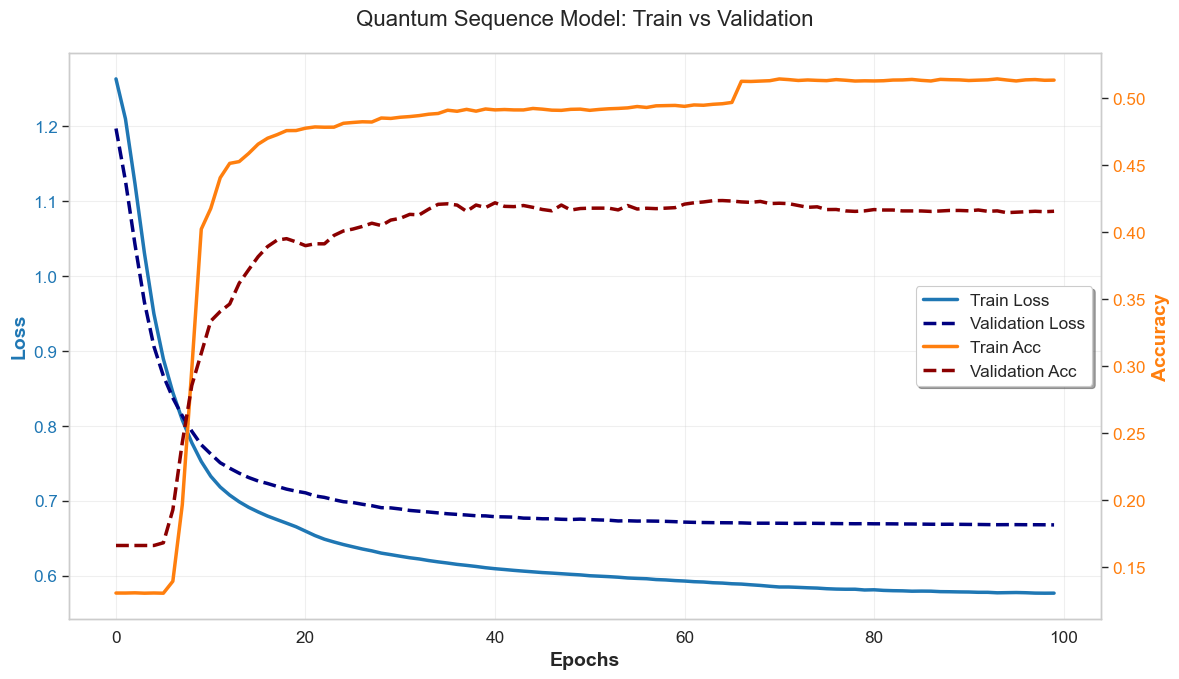

In [15]:
# Set the aesthetic style
sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")

# Create figure and primary axis (Loss)
fig, ax1 = plt.subplots(figsize=(12, 7))

# --- Plot Loss (Left Axis) ---
color_train_loss = 'tab:blue'
color_val_loss = 'navy'

ax1.set_xlabel('Epochs', fontsize=14, fontweight='bold')
ax1.set_ylabel('Loss', color=color_train_loss, fontsize=14, fontweight='bold')

# Train Loss (Solid)
line1 = ax1.plot(loss_history, color=color_train_loss, linewidth=2.5, label='Train Loss')
# Val Loss (Dashed)
line2 = ax1.plot(val_loss_history, color=color_val_loss, linewidth=2.5, linestyle='--', label='Validation Loss')

ax1.tick_params(axis='y', labelcolor=color_train_loss)
ax1.grid(True, alpha=0.3)

# --- Plot Accuracy (Right Axis) ---
ax2 = ax1.twinx()
color_train_acc = 'tab:orange'
color_val_acc = 'darkred'

ax2.set_ylabel('Accuracy', color=color_train_acc, fontsize=14, fontweight='bold')

# Train Accuracy (Solid)
line3 = ax2.plot(acc_history, color=color_train_acc, linewidth=2.5, label='Train Acc')
# Val Accuracy (Dashed)
line4 = ax2.plot(val_acc_history, color=color_val_acc, linewidth=2.5, linestyle='--', label='Validation Acc')

ax2.tick_params(axis='y', labelcolor=color_train_acc)
ax2.grid(False)

# --- Combined Legend ---
lines = line1 + line2 + line3 + line4
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right', frameon=True, fancybox=True, shadow=True)

# Title and Layout
plt.title('Quantum Sequence Model: Train vs Validation', fontsize=16, pad=20)
plt.tight_layout()

plt.show()

## Final Test Phase: Unbiased Evaluation

This section performs the final evaluation of the optimized model on the **Test Set**, which has been completely withheld during the training and hyperparameter tuning phases.

**Objective:** To report the true generalization performance of the model on unseen data.

**Process:**
1.  **Load Best Model:** We load the model parameters that achieved the lowest validation loss.
2.  **Conditioned Generation:** For each set of molecular properties (LogP, QED, MW) in the Test Set, we generate a new molecule.
3.  **Metric Calculation:** We compute standard generative metrics:
    * **Validity:** Percentage of generated sequences that decode to valid chemical structures.
    * **Uniqueness:** Percentage of valid molecules that are unique.
    * **Novelty:** Percentage of valid molecules that do not appear in the Training Set.

In [16]:
# Load best model parameters
ckpt_dir = '../data/params/'
with open(os.path.join(ckpt_dir, f"attention_params_{N_MOLECS}_{TIMESTAMP}_BEST.pkl"), "rb") as f:
    combined_params = pickle.load(f)

In [18]:
def molecule_stochastic_generation(key, props, combined_params, temperature=0.7):
    """
    Generate a molecule in SELFIES format using the trained model.
    Args:
        key: JAX PRNGKey for randomness.
        props: Molecular properties (shape: 3,).
        combined_params: Dictionary of trained model parameters.
        temperature: Sampling temperature for diversity.
    Returns:
        generated_bits: List of jnp.ndarray, each of shape (BITS_PER_TOKEN,).
    """
    embedding_table = combined_params['embedding_table']
    W_Q = combined_params['W_Q']
    W_K = combined_params['W_K']
    W_V = combined_params['W_V']
    theta = combined_params['theta']
    gamma = combined_params['gamma']
    sigma_params = combined_params['sigma']
    
    generated_bits = []
    
    # Store the projected Keys and Values for history
    past_Ks = []
    past_Vs = []
    
    current_token_index = SOS_index
    current_token_bits = jnp.array(list(map(int, format(SOS_index, f'0{BITS_PER_TOKEN}b'))), dtype=jnp.int32)
    local_rng = key 
    
    for t in range(MAX_LEN):
        local_rng, subkey = random.split(local_rng)

        # 1. Embedding & Position Encoding (Same as Training)
        x_token = current_token_bits 
        current_token_index = bits_to_index(x_token)
        x_i = embedding_table[current_token_index]

        # Position matches 't' because we are at the t-th step of the sequence
        position = t
        dim_indices = jnp.arange(EMBEDDING_SIZE)
        positional_encoding = jnp.where(
            dim_indices % 2 == 0,
            jnp.sin(position / (10000 ** (dim_indices / EMBEDDING_SIZE))),
            jnp.cos(position / (10000 ** ((dim_indices-1) / EMBEDDING_SIZE)))
        )
        x_i_pos = x_i + positional_encoding

        # 2. Projections
        Q_i = x_i_pos @ W_Q
        K_i = x_i_pos @ W_K
        V_i = x_i_pos @ W_V
        
        # 3. Uptime History 
        # Add current K_i and V_i to history BEFORE computing attention
        past_Ks.append(K_i)
        past_Vs.append(V_i)

        # Attention Calculation
        # Stack lists into arrays for matrix multiplication
        # K_mat shape: (t+1, proj_dim)
        K_mat = jnp.stack(past_Ks)
        V_mat = jnp.stack(past_Vs)
        
        d_k = W_Q.shape[-1]
        
        # Calculate scores against ALL tokens seen so far (including current)
        # Q_i (dim) @ K_mat.T (dim, t+1) -> (t+1) scores
        scores = jnp.matmul(Q_i, K_mat.T) / jnp.sqrt(d_k)
        weights = jnn.softmax(scores)
        
        # Context vector
        output_i = jnp.dot(weights, V_mat)

        # 5. Prediction (Quantum Model)
        pred_probs = autoregressive_model(x_token, props, theta, gamma, sigma_params, output_i)
        
        # 6. Tempering & Sampling
        logits = jnp.log(pred_probs[:VOCABULARY_SIZE] + 1e-10)

        logit_mask = jnp.zeros((VOCABULARY_SIZE,))
        logit_mask = logit_mask.at[PAD_index].set(-1e9)
        logit_mask = logit_mask.at[SOS_index].set(-1e9)
        
        masked_logits = logits + logit_mask
        tempered_logits = masked_logits / temperature
        tempered_probs = jnn.softmax(tempered_logits)
        
        token_indices = jnp.arange(VOCABULARY_SIZE)
        next_index = random.choice(subkey, token_indices, p=tempered_probs)

        next_bits_str = format(int(next_index), f'0{BITS_PER_TOKEN}b')
        next_bits = jnp.array([int(b) for b in next_bits_str], dtype=jnp.int32)

        if int(next_index) == EOS_index:
            break

        generated_bits.append(next_bits)
        
        # Uptime for next iteration
        current_token_bits = next_bits 

    return generated_bits


def bits_to_selfies_smiles(generated_bits):
    """
    Convert a list of bit arrays to SELFIES string and SMILES string.
    Args:
        generated_bits: List of jnp.ndarray, each of shape (BITS_PER_TOKEN,)
    Returns:
        Tuple of:
            - selfies_str: Generated SELFIES string
            - smiles_str: Decoded SMILES string (or None if decoding fails)
    """
    selfies_tokens = []
    for bits in generated_bits:
        index = int("".join(map(str, bits)), 2)
        
        if index >= VOCABULARY_SIZE:
            break

        token = ALPHABET[int(index)]
        if token == '<EOS>':
            break
        selfies_tokens.append(token)
    
    selfies_str = ''.join(selfies_tokens)
    # Use error handling for decoding
    try:
        smiles_str = sf.decoder(selfies_str)
    except:
        smiles_str = None
    return selfies_str, smiles_str

In [19]:
def calculate_validity(generated_smiles_list):
    """
    Calculates the percentage of generated sequences that are chemically valid.
    Returns the score and the list of valid RDKit molecules (as SMILES).
    """
    valid_smiles = []
    for smi in generated_smiles_list:
        # Basic check: string is not None or empty
        if not smi:
            continue
        
        # RDKit check
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            valid_smiles.append(smi)
            
    if len(generated_smiles_list) == 0:
        return 0.0, []
        
    score = len(valid_smiles) / len(generated_smiles_list)
    return score, valid_smiles


def calculate_uniqueness(valid_smiles_list):
    """
    Calculates the percentage of unique molecules among the VALID ones.
    """
    if len(valid_smiles_list) == 0:
        return 0.0
    
    unique_smiles = set(valid_smiles_list)
    score = len(unique_smiles) / len(valid_smiles_list)
    return score


def calculate_novelty(valid_smiles_list, training_smiles_set):
    """
    Calculates the percentage of valid molecules that do NOT appear in the training set.
    """
    if len(valid_smiles_list) == 0:
        return 0.0
    
    # Count how many generated molecules are NOT in the training set
    novel_mols = [s for s in valid_smiles_list if s not in training_smiles_set]
    
    score = len(novel_mols) / len(valid_smiles_list)
    return score



def load_training_smiles_for_novelty(train_csv_path):
    """
    Reads the Training CSV tokens and converts them back to SMILES 
    to build the reference set for Novelty.
    """
    print(f"Loading Training Data for Novelty check: {train_csv_path}")
    
    # --- FIX: Read everything as string to preserve "00000" format ---
    df = pd.read_csv(train_csv_path, dtype=str)
    
    training_smiles = set()
    
    # Get token columns
    token_cols = [c for c in df.columns if 'token_' in c]
    
    for _, row in df.iterrows():
        # Extract token bits
        tokens_bits = [row[col] for col in token_cols]
        
        mol_tokens = []
        for bit_str in tokens_bits:
            # Handle potential NaNs from string conversion
            if pd.isna(bit_str) or bit_str == 'nan': 
                continue
            
            try:
                idx = int(bit_str, 2)
                
                if idx < len(ALPHABET):
                    token = ALPHABET[idx]
                    if token == '<EOS>': break
                    mol_tokens.append(token)
            except ValueError:
                continue # Skip malformed bits
        
        # Decode SELFIES to SMILES
        try:
            smi = sf.decoder("".join(mol_tokens))
            if smi:
                training_smiles.add(smi)
        except:
            continue
            
    print(f"Found {len(training_smiles)} unique molecules in Training Set.")
    return training_smiles

In [20]:
'''# Load Reference Data
training_set_smiles = load_training_smiles_for_novelty(data_path_train)

# Load Test Data
test_df = pd.read_csv(data_path_test)
print(f"Loaded Test Data: {len(test_df)} samples")


print("Starting Generation...")
start_time = time.time()

generated_smiles_list = []
target_props_list = []

# JAX Random Key
key = jax.random.PRNGKey(int(time.time()))

# Loop through the Test Set
# Generate 1 molecule for every row in the test set, using THAT row's properties
for i, row in test_df.iterrows():
    
    # 1. Get Properties from Test Data
    props = jnp.array([row['logP'], row['qed'], row['mw']], dtype=jnp.float32)
    
    # 2. Split Key for randomness
    key, subkey = jax.random.split(key)
    
    # 3. Generate molecule using the BEST parameters loaded
    gen_bits = molecule_stochastic_generation(
        subkey, 
        props, 
        combined_params, 
        temperature=0.9)
    
    # 4. Decode to SMILES
    _, gen_smi = bits_to_selfies_smiles(gen_bits)
    
    generated_smiles_list.append(gen_smi)
    target_props_list.append(props)

print(f"Generation finished in {time.time() - start_time:.2f}s")
'''

Loading Training Data for Novelty check: ../data/structured_data_selfies_1000_train.csv
Found 648 unique molecules in Training Set.
Loaded Test Data: 143 samples
Starting Generation...
Generation finished in 1195.81s


In [40]:
import time
from rdkit import Chem
from rdkit.Chem import Descriptors, QED

# ==========================================
# 1. SETUP & DATA LOADING
# ==========================================

# Calculate Ranges (Needed to un-scale the normalized inputs)
range_logp = max_logp - min_logp
range_qed  = max_qed - min_qed
range_mw   = max_mw - min_mw

print(f"Ranges -> LogP: {range_logp:.2f}, QED: {range_qed:.2f}, MW: {range_mw:.2f}")

# Load Reference Data for Novelty
training_set_smiles = load_training_smiles_for_novelty(data_path_train)

# Load Test Data (User confirmed these are ALREADY NORMALIZED)
test_df = pd.read_csv(data_path_test)
print(f"Loaded Test Data: {len(test_df)} samples")

print("Starting Generation (5 candidates per input)...")
start_time = time.time()

all_generated_smiles = [] 
best_molecules_for_plot = []
key = jax.random.PRNGKey(int(time.time()))
K_SAMPLES = 5

# ==========================================
# 2. GENERATION LOOP
# ==========================================

for i, row in test_df.iterrows():
    # 1. Get Normalized Inputs (For the Model)
    norm_logp = float(row['logP'])
    norm_qed  = float(row['qed'])
    norm_mw   = float(row['mw'])
    
    target_props_norm = jnp.array([norm_logp, norm_qed, norm_mw], dtype=jnp.float32)
    
    # 2. Calculate Raw Targets (For Error Calculation & Plotting)
    tgt_raw_logp = denormalize(norm_logp, min_logp, max_logp)
    tgt_raw_qed  = denormalize(norm_qed, min_qed, max_qed)
    tgt_raw_mw   = denormalize(norm_mw, min_mw, max_mw)
    
    target_props_raw = [tgt_raw_logp, tgt_raw_qed, tgt_raw_mw]
    
    current_candidates = []
    
    # 3. Inner Loop: Generate K samples
    for k in range(K_SAMPLES):
        key, subkey = jax.random.split(key)
        
        # --- GENERATION (Uses Normalized) ---
        gen_bits = molecule_stochastic_generation(
            subkey, 
            target_props_norm,
            combined_params, 
            temperature=0.9
        )
        
        _, gen_smi = bits_to_selfies_smiles(gen_bits)
        all_generated_smiles.append(gen_smi)
        
        if gen_smi:
            mol = Chem.MolFromSmiles(gen_smi)
            if mol:
                try:
                    # RDKit returns RAW physical values
                    act_logp = Descriptors.MolLogP(mol)
                    act_qed = QED.qed(mol)
                    act_mw = Descriptors.MolWt(mol)
                    
                    # --- ERROR CALCULATION (In Raw Space) ---
                    # We normalize the *difference* so properties have equal weight
                    err_logp = abs(act_logp - tgt_raw_logp) / range_logp
                    err_qed  = abs(act_qed  - tgt_raw_qed)  / range_qed
                    err_mw   = abs(act_mw   - tgt_raw_mw)   / range_mw
                    
                    total_err = err_logp + err_qed + err_mw
                    
                    current_candidates.append({
                        'mol': mol,
                        'smiles': gen_smi,
                        'act_props': [act_logp, act_qed, act_mw], # Raw Actuals
                        'tgt_props': target_props_raw,             # Raw Targets
                        'error': total_err
                    })
                except:
                    pass

    # 4. Select Best Match
    if current_candidates:
        best_candidate = sorted(current_candidates, key=lambda x: x['error'])[0]
        best_molecules_for_plot.append(best_candidate)

# ==========================================
# 3. METRICS & PLOTTING DATA PREP
# ==========================================

print(f"Generation finished in {time.time() - start_time:.2f}s")

# Global Metrics
validity_score, valid_smiles_list = calculate_validity(all_generated_smiles)
uniqueness_score = calculate_uniqueness(valid_smiles_list)
novelty_score = calculate_novelty(valid_smiles_list, training_set_smiles)

print(f"Validity: {validity_score*100:.2f}%")
print(f"Uniqueness: {uniqueness_score*100:.2f}%")
print(f"Novelty: {novelty_score*100:.2f}%")

# Prep for Parity Plots (Using the Raw values we calculated)
print(f"Selected {len(best_molecules_for_plot)} best matches.")


Ranges -> LogP: 6.19, QED: 0.42, MW: 224.97
Loading Training Data for Novelty check: ../data/structured_data_selfies_1000_train.csv
Found 648 unique molecules in Training Set.
Loaded Test Data: 143 samples
Starting Generation (5 candidates per input)...
Generation finished in 5983.03s
Validity: 99.02%
Uniqueness: 85.88%
Novelty: 100.00%
Selected 143 best matches.


In [41]:
def plot_property_distributions(combined_df):
    """
    Plots the distribution of properties for Generated vs Test Set molecules.
    """
    # Set style
    sns.set_context("paper", font_scale=1.4)
    sns.set_style("whitegrid")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    properties = ['LogP', 'QED', 'MW']
    colors = {'Test Set (Ground Truth)': 'grey', 'Generated': 'tab:blue'}
    
    for i, prop in enumerate(properties):
        ax = axes[i]
        
        # Plot KDE (Kernel Density Estimate)
        sns.kdeplot(
            data=combined_df, 
            x=prop, 
            hue='Source', 
            fill=True, 
            common_norm=False, 
            palette=colors,
            alpha=0.3, 
            linewidth=2.5,
            ax=ax
        )
        
        ax.set_title(f'{prop} Distribution', fontweight='bold')
        ax.set_xlabel(prop)
        ax.set_ylabel('Density')
        
    plt.tight_layout()
    plt.show()


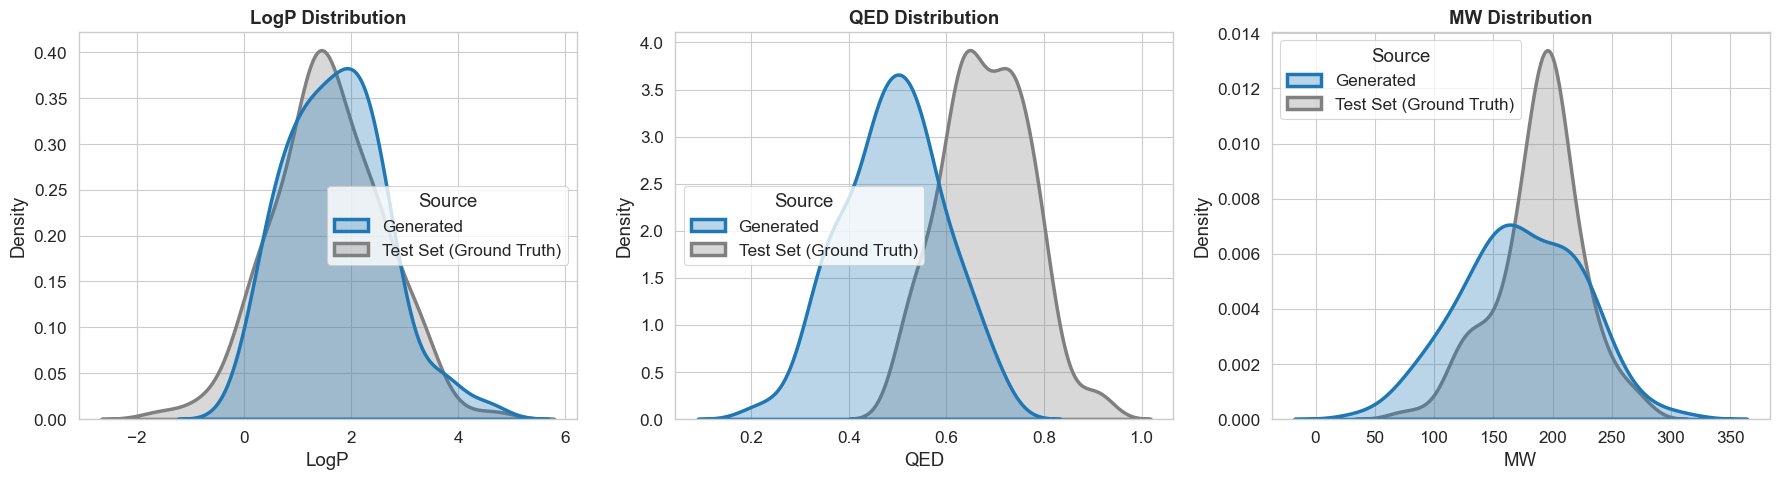

In [42]:
# Create Combined DataFrame for your plot function
gen_data = []
for d in best_molecules_for_plot:
    gen_data.append({
        'LogP': d['act_props'][0],
        'QED':  d['act_props'][1],
        'MW':   d['act_props'][2],
        'Source': 'Generated'
    })

truth_data = []
for d in best_molecules_for_plot:
    truth_data.append({
        'LogP': d['tgt_props'][0],
        'QED':  d['tgt_props'][1],
        'MW':   d['tgt_props'][2],
        'Source': 'Test Set (Ground Truth)'
    })

combined_df = pd.concat([pd.DataFrame(gen_data), pd.DataFrame(truth_data)], ignore_index=True)

# Now call your plot function
plot_property_distributions(combined_df)

----------------------------------------------------

In [22]:
'''# ------ Calculate Metrics ------

# Validity
val_score, valid_mols = calculate_validity(generated_smiles_list)

# Uniqueness (Calculated only on valid molecules)
uniq_score = calculate_uniqueness(valid_mols)

# Novelty (Calculated only on valid molecules vs Training Set)
nov_score = calculate_novelty(valid_mols, training_set_smiles)

print(f"Number of generated samples: {len(generated_smiles_list)}")
print(f"Validity:   {val_score:.2%}  ({len(valid_mols)} valid)")
print(f"Uniqueness: {uniq_score:.2%}")
print(f"Novelty:    {nov_score:.2%}")'''

Number of generated samples: 143
Validity:   99.30%  (142 valid)
Uniqueness: 95.07%
Novelty:    100.00%


------- Temperature = 0.9

Number of generated samples: 1420
Validity:   97.82%  (1389 valid)
Uniqueness: 78.19%
Novelty:    99.93%
[03:13:11] WARNING: not removing hydrogen atom without neighbors
[03:13:11] WARNING: not removing hydrogen atom without neighbors
[03:13:11] WARNING: not removing hydrogen atom without neighbors
[03:13:11] WARNING: not removing hydrogen atom without neighbors

In [23]:
# Save generated molecules to CSV for inspection
results_df = pd.DataFrame({
    'Target_LogP': [float(p[0]) for p in target_props_list],
    'Target_QED': [float(p[1]) for p in target_props_list],
    'Target_MW': [float(p[2]) for p in target_props_list],
    'Generated_SMILES': generated_smiles_list
})

results_df.to_csv(f"../generation/final_results_{N_MOLECS}_{TIMESTAMP}.csv", index=False)
print("Saved generation results to CSV.")

Saved generation results to CSV.


In [24]:
def calculate_generated_properties(results_df):
    """
    Calculates actual physicochemical properties for the generated SMILES.
    """
    print("Calculating properties for generated molecules...")
    
    actual_logp = []
    actual_qed = []
    actual_mw = []
    valid_indices = []

    for idx, row in results_df.iterrows():
        smi = row['Generated_SMILES']

        try:
            mol = Chem.MolFromSmiles(smi)
            if mol:
                # Calculate properties
                actual_logp.append(Descriptors.MolLogP(mol))
                actual_qed.append(QED.qed(mol))
                actual_mw.append(Descriptors.MolWt(mol))
                valid_indices.append(idx)
        except:
            # Catch RDKit internal C++ errors just in case
            continue
            
    # Create a new DataFrame for valid generated molecules
    gen_props_df = pd.DataFrame({
        'LogP': actual_logp,
        'QED': actual_qed,
        'MW': actual_mw,
        'Source': 'Generated'
    })
    
    return gen_props_df, valid_indices


Calculating properties for generated molecules...


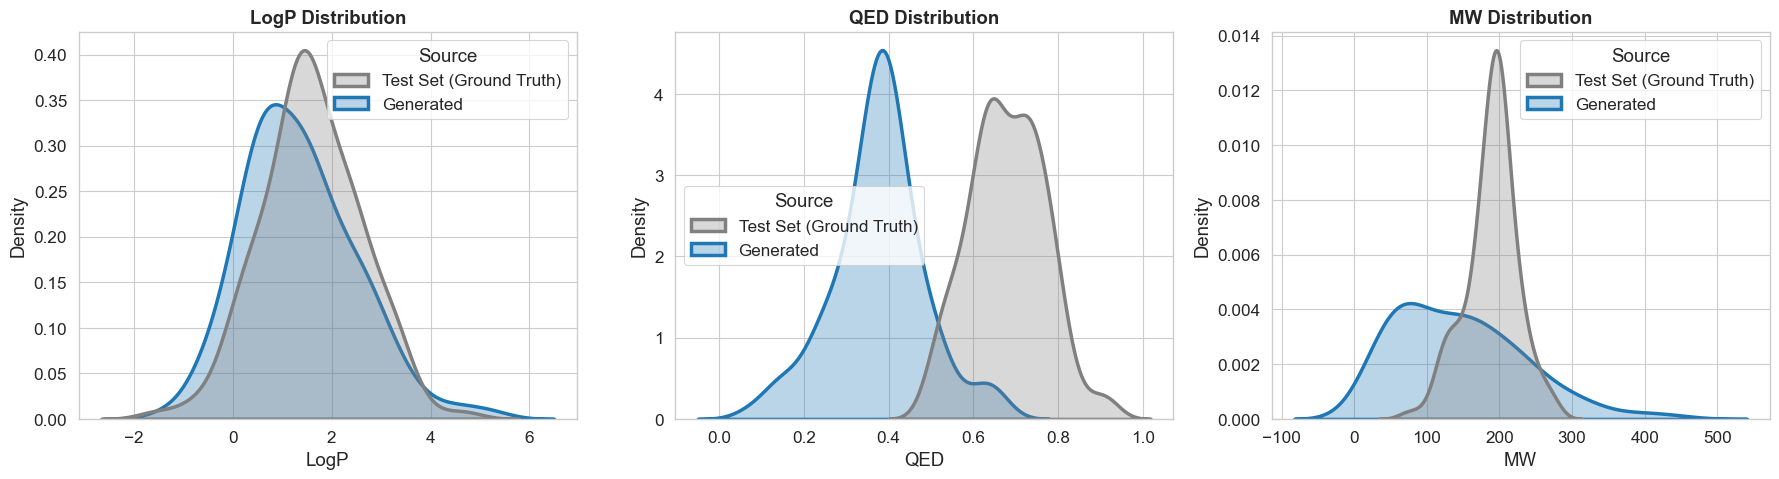

In [26]:
# Get Target Properties and DE-NORMALIZE them
RESULTS_PATH = f"../generation/final_results_{N_MOLECS}_{TIMESTAMP}.csv"
results_df = pd.read_csv(RESULTS_PATH)

gen_props_df, valid_indices = calculate_generated_properties(results_df)
test_props_df = results_df.loc[valid_indices, ['Target_LogP', 'Target_QED', 'Target_MW']].copy()

# Apply de-normalization (using the min/max values from your load_molecules.ipynb)
# You need to make sure min_logp, max_logp, etc. are available here!
test_props_df['Target_LogP'] = test_props_df['Target_LogP'].apply(lambda x: denormalize(x, min_logp, max_logp))
test_props_df['Target_QED'] = test_props_df['Target_QED'].apply(lambda x: denormalize(x, min_qed, max_qed))
test_props_df['Target_MW'] = test_props_df['Target_MW'].apply(lambda x: denormalize(x, min_mw, max_mw))

test_props_df.columns = ['LogP', 'QED', 'MW']
test_props_df['Source'] = 'Test Set (Ground Truth)'

combined_df = pd.concat([test_props_df, gen_props_df], axis=0) 

# Plot
plot_property_distributions(combined_df)

properties in multiRZ
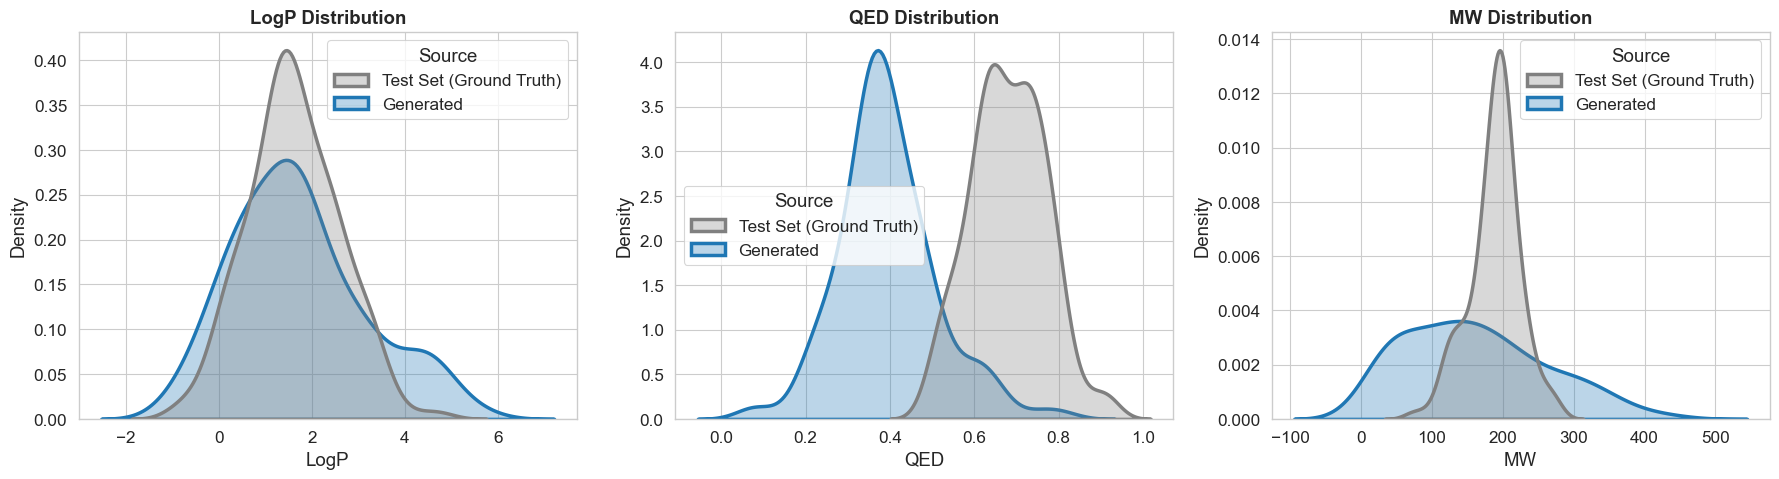

no prop 1k molecs


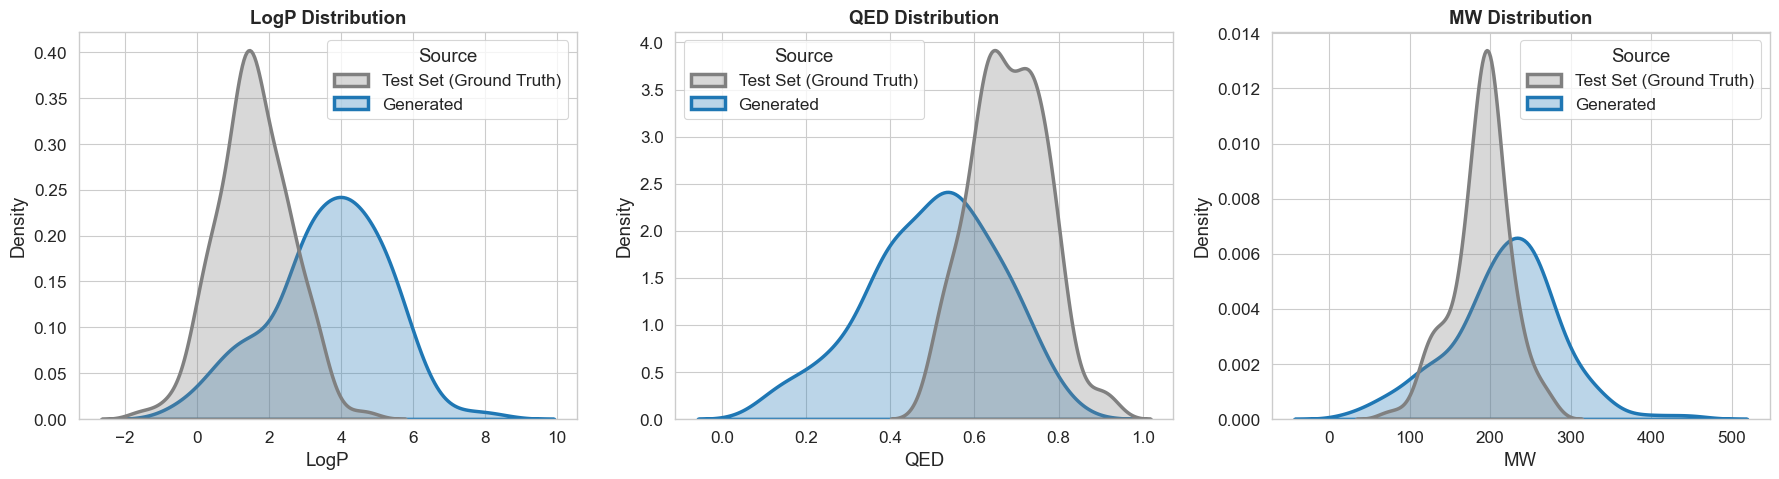

-------- 10k molect, temperaure = 0.9
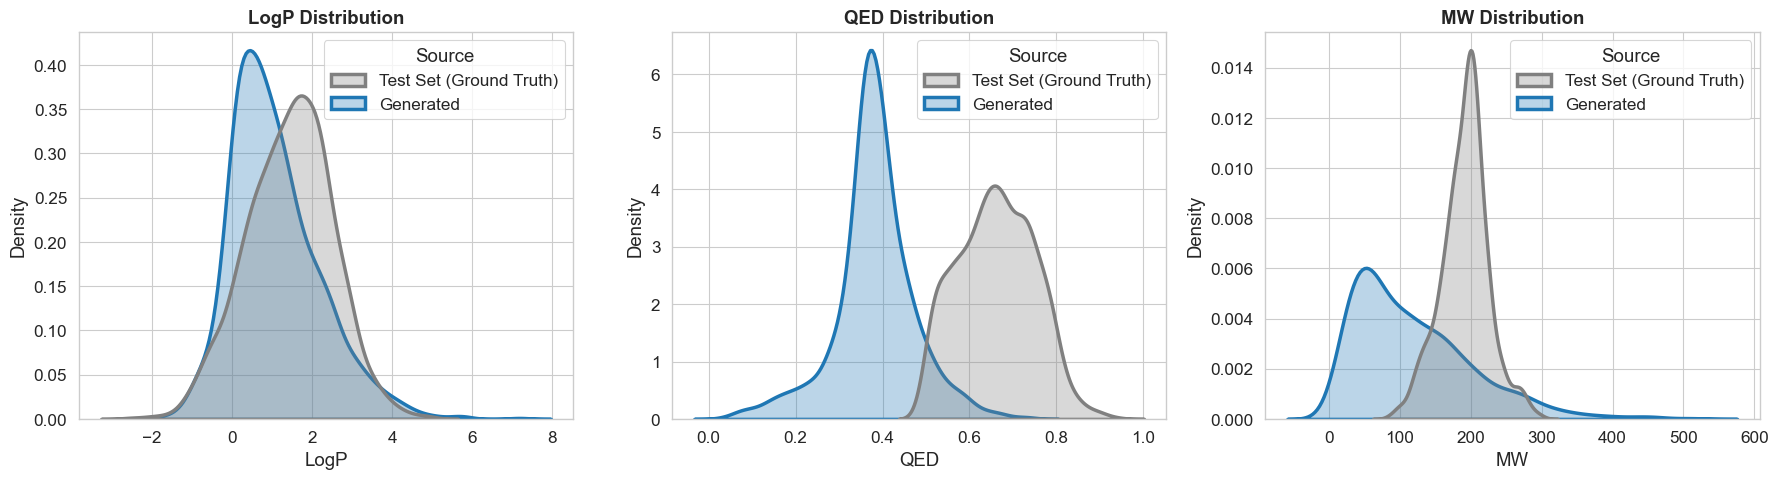

Ranking molecules by Target-Match Accuracy...
Drawing top 9 most accurate generations...


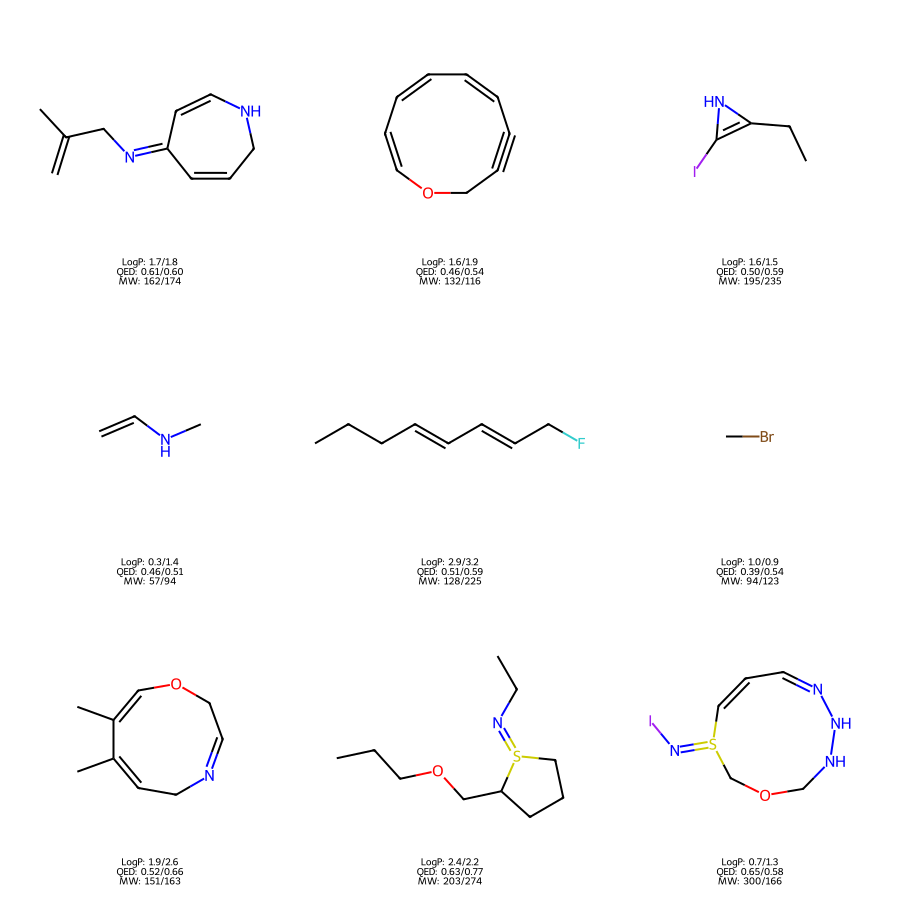

In [27]:
print("Ranking molecules by Target-Match Accuracy...")

molecules_to_draw = []
errors = []

for idx, row in results_df.iterrows():
    smi = row['Generated_SMILES']
    if not smi or pd.isna(smi):
        continue
        
    mol = Chem.MolFromSmiles(smi)
    if not mol:
        continue

    # A. Calculate Actual Properties
    act_logp = Descriptors.MolLogP(mol)
    act_qed = QED.qed(mol)
    act_mw = Descriptors.ExactMolWt(mol)
    
    # B. Get Target Properties (De-normalized)
    # Note: Ensure your CSV saved them as Normalized. 
    # If you saved de-normalized values already, skip the 'denorm' call.
    tgt_logp = denormalize(row['Target_LogP'], min_logp, max_logp)
    tgt_qed = denormalize(row['Target_QED'], min_qed, max_qed)
    tgt_mw = denormalize(row['Target_MW'], min_mw, max_mw)

    
    # C. Calculate Error (Mean Squared Error between Target and Actual)
    # We normalize the differences so MW doesn't dominate the error score
    # (e.g. MW error of 10 is small, but QED error of 10 is impossible)
    diff_logp = (act_logp - tgt_logp) ** 2
    diff_qed = (act_qed - tgt_qed) ** 2 * 100 # Scale up QED importance
    diff_mw = ((act_mw - tgt_mw) / 100) ** 2  # Scale down MW importance
    
    total_error = diff_logp + diff_qed + diff_mw
    
    molecules_to_draw.append({
        'mol': mol,
        'smiles': smi,
        'error': total_error,
        'legend': f"LogP: {act_logp:.1f}/{tgt_logp:.1f}\nQED: {act_qed:.2f}/{tgt_qed:.2f}\nMW: {act_mw:.0f}/{tgt_mw:.0f}"
    })

# --- 4. Sort and Select Top K ---
# Sort by lowest error (Best Match)
best_molecules = sorted(molecules_to_draw, key=lambda x: x['error'])[:9] # Top 9

# --- 5. Draw Grid ---
print(f"Drawing top {len(best_molecules)} most accurate generations...")

img = Draw.MolsToGridImage(
    [x['mol'] for x in best_molecules],
    molsPerRow=3,
    subImgSize=(300, 300),
    legends=[x['legend'] for x in best_molecules], # Shows Actual / Target
    returnPNG=False
)
# Display (if in notebook)
display(img)

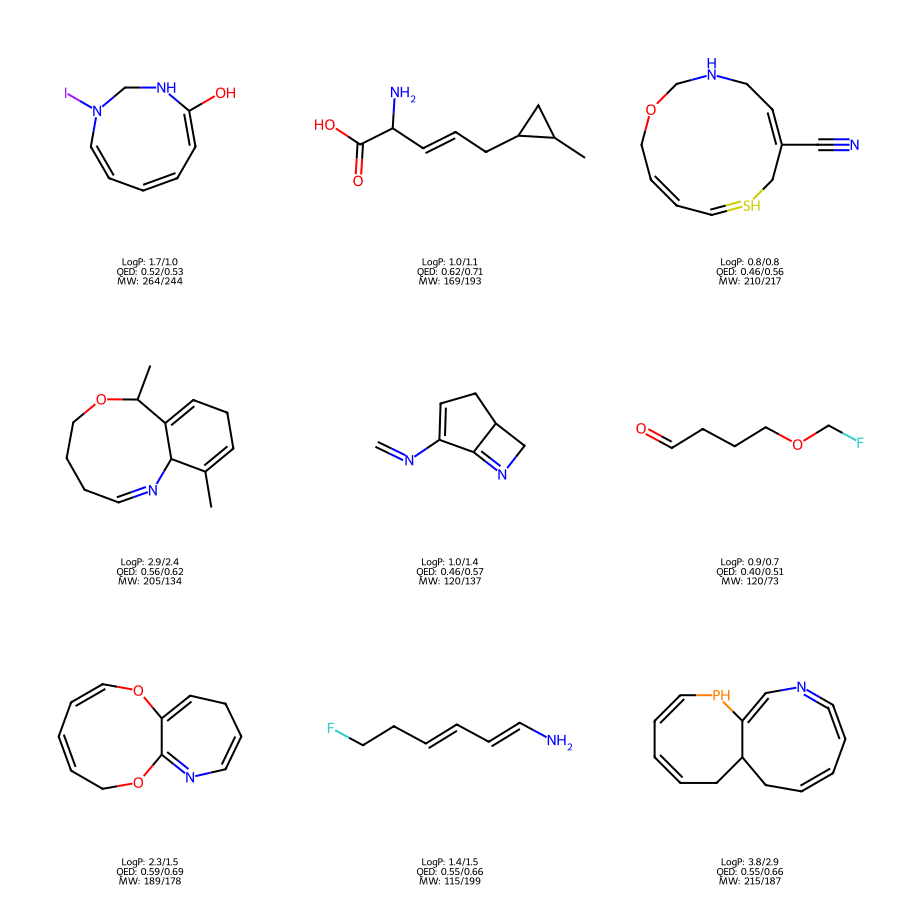

------------------------------------------------------------------

## Stochastic Generation with Tempering

To generate novel molecules, we run the trained model autoregressively.
* **Tempering:** We apply a temperature factor $T$ to the logits ($p_i = \frac{\exp(z_i/T)}{\sum \exp(z_j/T)}$) to control the diversity of the output.
* **Masking:** We explicitly mask invalid start/pad tokens to ensure the generator produces syntactically valid sequences.

In [28]:
N_MOLECS = 100  # Number of molecules to generate
MASTER_KEY = jax.random.PRNGKey(42)  # Fixed key for reproducibility
TEMPERATURE = 0.6  # Sampling temperature

# Target properties (mid-range example normalized to [0, pi])
desired_logp = 1.2
desired_qed = 0.71
desired_mw = 205.0

norm_logp = normalize(desired_logp, min_logp, max_logp)
norm_qed = normalize(desired_qed, min_qed, max_qed)
norm_mw = normalize(desired_mw, min_mw, max_mw)
desired_props = jnp.array([norm_logp, norm_qed, norm_mw], dtype=jnp.float32)

print(f"Target Properties (Normalized to [0, pi]):")
print(f"   LogP: {norm_logp:.3f}, QED: {norm_qed:.3f}, MW: {norm_mw:.3f}\n")


def generate_molecules(props, params):
    selfies_list = []
    smiles_list = []
    keys = jax.random.split(MASTER_KEY, N_MOLECS)
    for i in range(N_MOLECS):
        rng_i = keys[i]
        generated_bits = molecule_stochastic_generation(rng_i, props, params, temperature=TEMPERATURE)
        generated_selfies, generated_smiles = bits_to_selfies_smiles(generated_bits)
        selfies_list.append(generated_selfies)
        smiles_list.append(generated_smiles)
    return selfies_list, smiles_list

selfies_list, smiles_list = generate_molecules(desired_props, combined_params)

Target Properties (Normalized to [0, pi]):
   LogP: 1.386, QED: 1.571, MW: 1.841



KeyboardInterrupt: 

In [ ]:
def analyze_molecule_properties(selfies_list, smiles_list, target_logp, target_qed, target_mw):
    """
    Calculates and prints the physicochemical properties for generated molecules,
    comparing them directly against the denormalized targets.
    Args:
        selfies_list: List of generated SELFIES strings
        smiles_list: List of generated SMILES strings
        target_logp: Target LogP value (denormalized)
        target_qed: Target QED value (denormalized)
        target_mw: Target Molecular Weight (denormalized)
    Returns:
        DataFrame with properties of generated molecules and comparison to target
    """
    results = []
    
    # Print Denormalized Target Properties
    print(f"\n--- Target Properties ---")
    print(f"LogP: {target_logp:.2f}")
    print(f"QED: {target_qed:.2f}")
    print(f"MW: {target_mw:.2f} g/mol")
    print("-" * 35)

    for i, (smiles, selfies) in enumerate(zip(smiles_list, selfies_list)):
        # Handle empty/invalid SMILES from generation failure
        if not smiles:
            results.append({"Molecule": i+1, "SMILES": "N/A", "LogP": np.nan, "QED": np.nan, "MW": np.nan})
            continue

        mol = Chem.MolFromSmiles(smiles)

        if mol is not None:
            try:
                logp = Descriptors.MolLogP(mol)
                qed_score = QED.qed(mol)
                mw = Descriptors.ExactMolWt(mol)

                results.append({
                    "Molecule": i+1,
                    "SELFIES": selfies,
                    "SMILES": smiles,
                    "LogP": logp,
                    "QED": qed_score,
                    "MW": mw,
                    "Validity": "Valid"
                })
            except Exception:
                 results.append({"Molecule": i+1, "SELFIES": selfies, "SMILES": smiles, "LogP": np.nan, "QED": np.nan, "MW": np.nan, "Validity": "Error"})
        else:
            results.append({"Molecule": i+1, "SELFIES": selfies, "SMILES": smiles, "LogP": np.nan, "QED": np.nan, "MW": np.nan, "Validity": "Invalid"})

    # Create and display the DataFrame
    df = pd.DataFrame(results)
    
    # Add a row for the target properties for easy comparison
    target_row = pd.Series({
        "Molecule": "TARGET", 
        "SELFIES": "TARGET",
        "SMILES": "TARGET", 
        "LogP": target_logp, 
        "QED": target_qed, 
        "MW": target_mw
    }, name="TARGET").to_frame().T
    
    # Concatenate the target row and the results for visual comparison
    df_styled = pd.concat([target_row.set_index('Molecule'), df.set_index('Molecule')])
    
    # Format numerical columns for presentation
    df_styled = df_styled.apply(pd.to_numeric, errors='ignore').round(2)
    
    return df_styled

df_styled = analyze_molecule_properties(selfies_list, smiles_list, desired_logp, desired_qed, desired_mw)

# Save the results to a CSV file
output_csv_path = f"../generation/generated_selfies_{N_MOLECS}_{TIMESTAMP}.csv"
df_styled.to_csv(output_csv_path)


--- Target Properties ---
LogP: 1.20
QED: 0.71
MW: 205.00 g/mol
-----------------------------------


/var/folders/8w/bmwl8d950jz75tsw3l1xlnm80000gn/T/ipykernel_36554/2184548224.py:68: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_styled = df_styled.apply(pd.to_numeric, errors='ignore').round(2)


In [ ]:
def get_top_molecules(selfies_list, smiles_list, top_k=5, min_mw=150.0, min_qed=0.5):
    """
    Filters generated molecules by validity and properties, then returns the top K
    sorted by QED (drug-likeness).
    Args:
        selfies_list: List of generated SELFIES strings
        smiles_list: List of generated SMILES strings
        top_k: Number of top molecules to return
        min_mw: Minimum molecular weight to consider
        min_qed: Minimum QED score to consider
    Returns:
        DataFrame of top K molecules with their properties
    """
    valid_molecules = []

    print(f"Analyzing {len(smiles_list)} generated molecules...")

    for i, (smiles, selfies) in enumerate(zip(smiles_list, selfies_list)):
        # 1. Basic Validity Check
        if not smiles:
            continue
            
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue

        try:
            # 2. Calculate Properties
            mw = Descriptors.ExactMolWt(mol)
            qed_score = QED.qed(mol)
            logp = Descriptors.MolLogP(mol)

            # 3. Apply Filters (The "Quality Control")
            # We want molecules that are large enough (MW > 150) to be interesting
            # and drug-like enough (QED > 0.5) to be valid canditimes.
            if mw >= min_mw and qed_score >= min_qed:
                valid_molecules.append({
                    "Index": i,
                    "SMILES": smiles,
                    "SELFIES": selfies,
                    "LogP": logp,
                    "QED": qed_score,
                    "MW": mw
                })
        except Exception:
            continue

    # 4. Sort by QED (Best Drug-Likeness First)
    # You could also sort by similarity to target LogP if preferred
    valid_molecules.sort(key=lambda x: x['QED'], reverse=True)

    # 5. Select Top K
    top_molecules = valid_molecules[:top_k]
    
    print(f"Found {len(valid_molecules)} molecules passing filters.")
    print(f"Showing top {len(top_molecules)}:")

    return pd.DataFrame(top_molecules)


top_10_df = get_top_molecules(selfies_list, smiles_list, top_k=10)

# Display
pd.set_option('display.max_colwidth', 60) # Make columns wide enough to see strings
display(top_10_df)

Analyzing 100 generated molecules...
Found 20 molecules passing filters.
Showing top 10:


,Index,SMILES,SELFIES,LogP,QED,MW
0,99,C123CC=C1C2C3CC=C4CCCCC4C=CCC(C)CN,[C][C][C][=C][Ring1][=Branch1][C][Ring1][#Branch1][C][Ri...,4.6103,0.707744,283.230000
1,71,CCC=C1CC=CC=C1CN2CCC34C=C2OC=C3C4PF,[C][C][C][=C][C][C][=C][C][=C][Ring1][=Branch1][C][N][C]...,4.6019,0.702576,317.134479
2,72,C12CC13CCCCC3C=CCCC=CCC=C2C(C)CCN,[C][C][C][Ring1][Branch1][C][C][C][C][C][Ring1][=Branch1...,5.3905,0.694587,299.261300
3,57,CCC1=CC=CC1CNBr,[C][C][C][=C][C][=C][C][Ring1][Branch1][C][N][Br],2.4083,0.692638,201.015311
4,45,CCC1CC=CC=C1[NH1]CC=CC,[C][C][C][C][C][=C][C][=C][Ring1][=Branch1][NH1][C][C][=...,3.0221,0.650806,177.151750
5,54,CCCCCNC=CCN1CCC=C1C,[C][C][C][C][C][N][C][=C][C][N][C][C][C][=C][Branch1][C]...,2.8894,0.647175,208.193949
6,10,CCCNN1NCCCC=C1,[C][C][C][N][N][N][C][C][C][C][=C][Ring1][#Branch1][#Bra...,1.0151,0.636791,155.142248
7,70,C1(=O)OC1(C)C2CCC=C([PH1])ONCC=NOC2CC,[C][#Branch2][NH1][C][=O][=O][C][Branch1][C][=C][Ring1][...,1.9983,0.623442,299.116069
8,15,CC1CCCNC=NCC1C2CN=CC=C2CCCC=C,[C][C][C][C][C][N][C][=N][C][C][Ring1][=Branch2][C][C][N...,3.6337,0.608150,287.236148
9,74,C=1CC=C2CC=1N[NH1]CCCC=C2,[C][C][C][=C][C][C][Branch1][C][Ring1][=Branch1][Ring1][...,2.0347,0.589885,176.131349


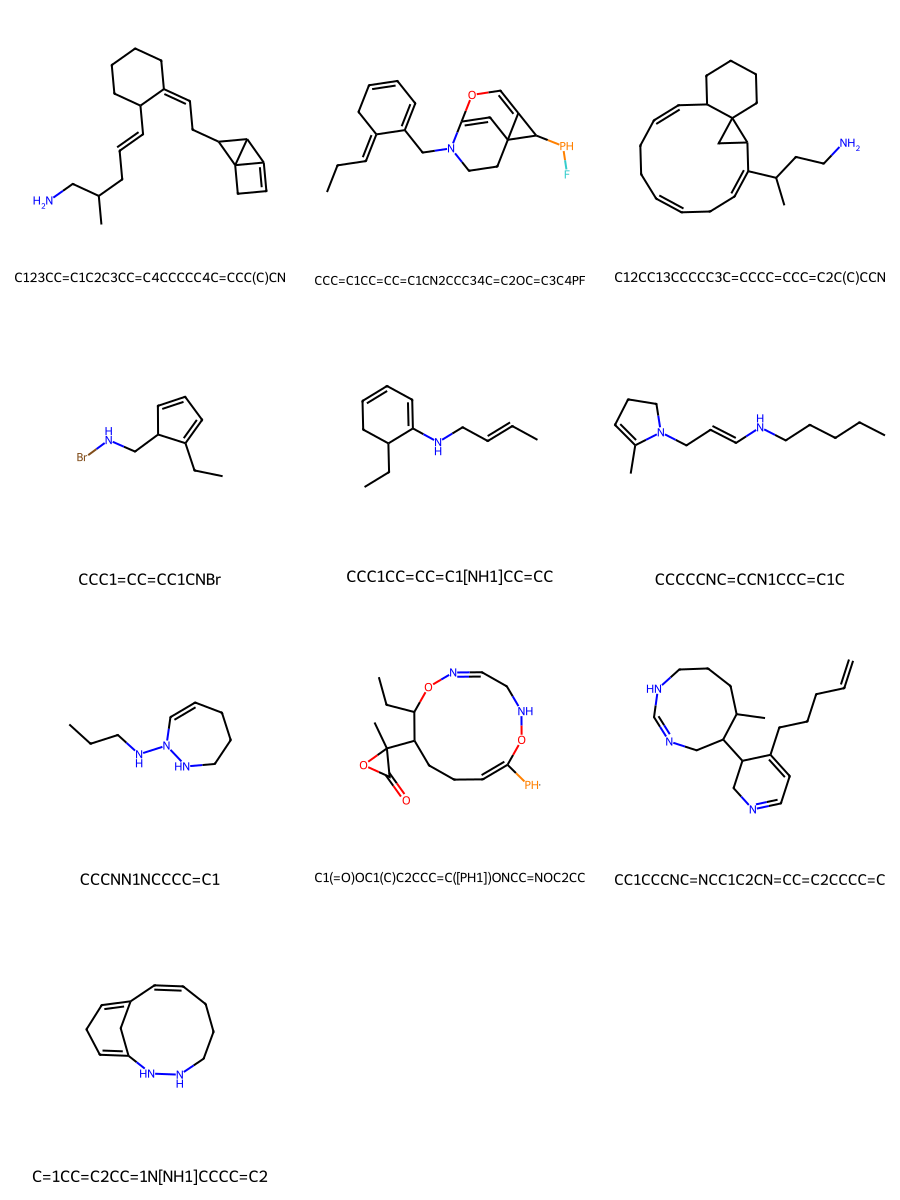

In [ ]:
# Generate the Molecules
mols = [Chem.MolFromSmiles(s) for s in top_10_df['SMILES']]

# Generate the Grid Image
img = Draw.MolsToGridImage(
    mols, 
    molsPerRow=3, 
    subImgSize=(300, 300), 
    legends=[top_10_df.iloc[i]['SMILES'] for i in range(len(mols))],
    returnPNG=False 
)

img.save(f"../generation/best_molecules_{N_MOLECS}_{TIMESTAMP}.png")

display(img)